# Practical 3: Vision Transformers

**Open notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/asci_cbl_practicals/blob/main/notebooks/3_Vision_Transformers.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/asci_cbl_practicals/blob/main/notebooks/3_Vision_Transformers.ipynb)    
**Authors:** Phillip Lippe

In this practical, we will take a closer look at a recent new trend: Transformers for Computer Vision. Since [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) successfully applied a Transformer on a variety of image recognition benchmarks, there have been an incredible amount of follow-up works showing that CNNs might not be optimal architecture for Computer Vision anymore. But how do Vision Transformers work exactly, and what benefits and drawbacks do they offer in contrast to CNNs? We will answer these questions by implementing a Vision Transformer ourselves and train it on the popular, small dataset CIFAR10.

Let's start with importing our standard set of libraries.

In [2]:
Colab_server=True
if Colab_server:
  from google.colab import drive
  drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
#DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
#CHECKPOINT_PATH = "../saved_models/practical3"

#CHECKPOINT_PATH = "/content/drive/MyDrive/saved_models/practical3"
#os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/home/ehsan/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/home/ehsan/saved_models/practical3"
if Colab_server:
  DATASET_PATH = "../data"
  CHECKPOINT_PATH = "/content/drive/MyDrive/saved_models/practical3"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

#!jupyter nbconvert --to script ...ipynb

import os
os.listdir(CHECKPOINT_PATH)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cpu


We load the CIFAR10 dataset below.

In [4]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# Create data loaders for later. Adjust batch size if you have a smaller GPU
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 40.4MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Files already downloaded and verified


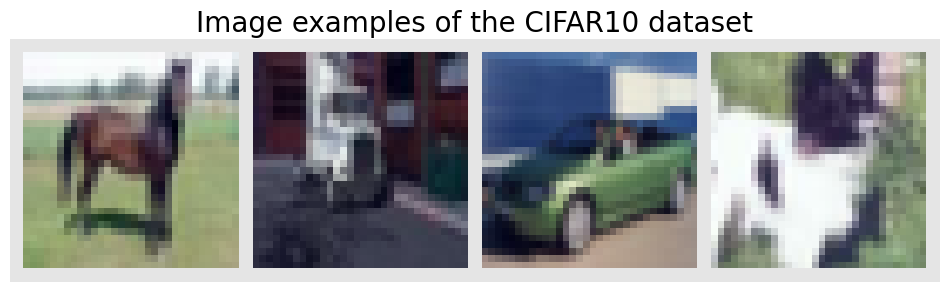

In [5]:
# For later, we keep a set of example images
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(4)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(12,8))
plt.title("Image examples of the CIFAR10 dataset", fontsize=20)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## Part 1: Building a Transformer for image classification

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. To apply Transformers to sequences, one commonly adds a positional encoding to the input feature vectors, and the model learns by itself what to do with it. So, why not do the same thing on images? This is exactly what [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) proposed in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. As a preprocessing step, we split an image of, for example, $48\times 48$ pixels into 9 $16\times 16$ patches. Each of those patches is considered to be a "word"/"token" and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task. A nice GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="https://github.com/Ehsan-aghapour/asci_cbl_practicals/blob/main/notebooks/figures/vit.gif?raw=1" width="600px"></center>

We will walk step by step through the Vision Transformer, and implement all parts by ourselves. First, let's implement the image preprocessing: an image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$. These represent the input words to the Transformer. Implement this logic in the function below:

In [6]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    Outputs:
        Tensor of shape [B, H*W/patch_size^2, C, patch_size, patch_size] if flatten_channels=False,
        and [B, H*W/patch_size^2, C*patch_size^2] otherwise.
    """
    B, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch size"

    patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5)  # [B, num_patches_h, num_patches_w, C, patch_size, patch_size]
    patches = patches.reshape(B, -1, C, patch_size, patch_size)  # Flatten spatial dimensions

    if flatten_channels:
        patches = patches.flatten(2)  # [B, num_patches, C*patch_size^2]

    return patches

In [7]:
imgs = torch.randn(4, 3, 48, 48)
patch_size = 16
out = img_to_patch(imgs, patch_size, flatten_channels=False)
assert len(out.shape) == 5
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == imgs.shape[2]*imgs.shape[3]/patch_size**2
assert out.shape[2] == imgs.shape[1]
assert out.shape[3] == patch_size
assert out.shape[4] == patch_size

out = img_to_patch(imgs, patch_size, flatten_channels=True)
assert len(out.shape) == 3
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == imgs.shape[2]*imgs.shape[3]/patch_size**2
assert out.shape[2] == imgs.shape[1]*patch_size**2

Let's take a look at how that works for our CIFAR examples above. For our images of size $32\times 32$, we choose a patch size of 4. Hence, we obtain sequences of 64 patches of size $4\times 4$. We visualize them below:

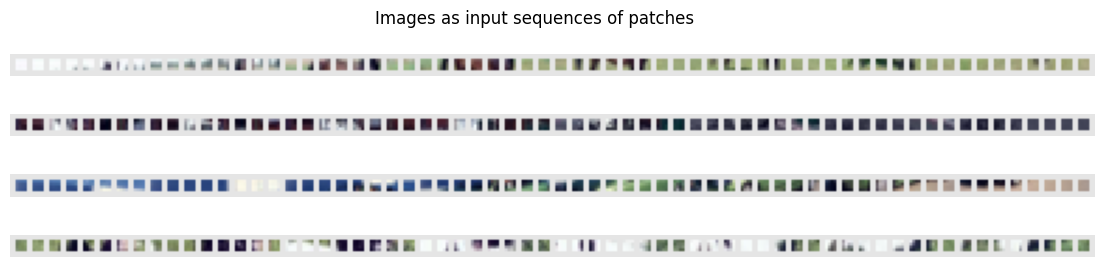

In [8]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from those patch lists now. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model. You can make use of the PyTorch module `nn.MultiheadAttention` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html?highlight=multihead#torch.nn.MultiheadAttention)) here. Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by [Ruibin Xiong et al.](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf) in 2020. The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage. A visualization of the difference between the standard Post-LN and the Pre-LN version is shown below.

<center width="100%"><img src="https://github.com/Ehsan-aghapour/asci_cbl_practicals/blob/main/notebooks/figures/pre_layer_norm.svg?raw=1" width="400px"></center>

First, implement a Pre-LN attention block below:

In [9]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        # TODO: Implement an pre-LN attention block
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        Inputs:
            x - Input tensor of shape [Num Patches, Batch size, embed_dim]
        """
        # TODO: Implement the forward pass
        # Multi-Head Attention
        x = x + self.attention(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        # Feed-Forward Network
        x = x + self.mlp(self.ln2(x))
        return x

In [10]:
# Testing the attention block
num_heads = np.random.randint(low=4, high=16)
embed_dim = num_heads * np.random.randint(low=16, high=32)
hidden_dim = np.random.randint(low=128, high=512)
block = AttentionBlock(embed_dim, hidden_dim, num_heads)
block.to(device)
inp = torch.randn(10, 32, embed_dim, device=device)
out = block(inp)
for i in range(len(inp.shape)):
    assert out.shape[i] == inp.shape[i]

# Checking whether batch and patch dimension are correct
inp2 = inp.clone()
inp2[:,0] = 0.0
out2 = block(inp2)
diff = (out - out2).abs()
assert (diff[:,0] > 1e-4).any(), 'Output tensor shows no difference although input has changed'
assert (diff[:,1:] < 1e-4).all(), 'Other tensors besides the changed batch element have altered outputs. Check the dimensions'

Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

* A **linear projection** layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each $M\times M$ patch independently as input.
* A **classification token** that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.
* Learnable **positional encodings** that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.
* An **MLP head** that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.

With those components in mind, let's implement the full Vision Transformer below:

In [11]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()
        # TODO: Implement all elements of the full Vision Transform
        self.patch_embedding = nn.Linear(num_channels * patch_size ** 2, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.positional_encoding = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.transformer = nn.Sequential(
            *[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        # TODO: Implement the forward pass
        B, C, H, W = x.shape
        patches = img_to_patch(x, int(H / math.sqrt(self.positional_encoding.size(1) - 1)))
        patches = self.patch_embedding(patches)  # Linear projection
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
        x = torch.cat((cls_tokens, patches), dim=1)  # Concatenate CLS token
        x += self.positional_encoding
        x = x.permute(1, 0, 2)  # Transformer expects [seq_len, batch_size, embed_dim]
        x = self.transformer(x)
        return self.mlp_head(x[0])  # Use CLS token for classification

In [12]:
# Testing the Vision Transformer module
num_heads = np.random.randint(low=4, high=16)
embed_dim = num_heads * np.random.randint(low=16, high=32)
hidden_dim = np.random.randint(low=128, high=512)
num_channels = 3
num_layers = np.random.randint(low=2, high=4)
num_classes = np.random.randint(low=5, high=20)
patch_size = [2,4,8][np.random.randint(low=0, high=3)]
num_patches = int((32/patch_size)**2)

vit_module = VisionTransformer(embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches)
vit_module.to(device)
imgs = torch.randn(4, 3, 32, 32, device=device)
out = vit_module(imgs)
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == num_classes

# Checking whether batch and patch dimension are correct
imgs2 = imgs.clone()
imgs2[0] = 0.0
out2 = vit_module(imgs2)
diff = (out2 - out).abs()
assert (diff[0] > 1e-4).any(), 'Output tensor shows no difference although input has changed'
assert (diff[1:] < 1e-4).all(), 'Other tensors besides the changed batch element have altered outputs. Check the dimensions'

Finally, we can put everything into a PyTorch Lightning Module as usual. We use `torch.optim.AdamW` as the optimizer, which is Adam with a corrected weight decay implementation. Since we use the Pre-LN Transformer version, we do not need to use a learning rate warmup stage anymore.

In [13]:


class ViT_0(pl.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")


class ViT(pl.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        # Just for demonstration; remove or adjust as needed
        # Typically, you'd do this in Lightning's "example_input_array" or "setup" methods
        self.example_input_array = next(iter(train_loader))[0]  # if train_loader is not empty

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        # Example LR scheduler
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Log differently for train, val, and test
        # IMPORTANT: for val, you must log "val_acc" with on_epoch=True so ModelCheckpoint sees it
        if mode == "train":
            self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
            self.log("train_acc",  acc,  on_step=True, on_epoch=True, prog_bar=True)
        elif mode == "val":
            self.log("val_loss", loss, on_epoch=True, prog_bar=True)
            self.log("val_acc",  acc,  on_epoch=True, prog_bar=True)
        else:  # test
            self.log("test_loss", loss, on_epoch=True)
            self.log("test_acc",  acc,  on_epoch=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")


In [14]:
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint,Callback

# Custom callback for periodic test accuracy logging
class PeriodicTestAccuracyLogger(Callback):
    def __init__(self, test_loader, print_freq=5):
        super().__init__()
        self.test_loader = test_loader
        self.print_freq = print_freq

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.print_freq == 0:
            test_results = trainer.test(dataloaders=self.test_loader, verbose=False)
            test_acc = test_results[0]['test_acc']
            print(f"Epoch {trainer.current_epoch}: Test Accuracy = {test_acc:.4f}")

## Experiments

Commonly, Vision Transformers are applied to large-scale image classification benchmarks such as ImageNet to leverage their full potential. However, here we take a step back and ask: can Vision Transformer also succeed on classical, small benchmarks such as CIFAR10? To find this out, we train a Vision Transformer from scratch on the CIFAR10 dataset. Let's first create a training function for our PyTorch Lightning module which also loads the pre-trained model if you have downloaded it above.

In [18]:
def train_or_resume():
    checkpoint_dir = "lightning_logs/checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    last_ckpt = os.path.join(checkpoint_dir, "last.ckpt")

    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        save_last=True,
        save_top_k=1,
        monitor="val_acc",
        mode="max",
    )

    trainer = pl.Trainer(
        max_epochs=100,
        accelerator="auto",
        callbacks=[checkpoint_callback],
        # ...
    )

    if os.path.isfile(last_ckpt):
        print(f"Resuming from {last_ckpt}")
        trainer.fit(model, train_loader, val_loader, ckpt_path=last_ckpt)
    else:
        print("No existing checkpoint. Training from scratch.")
        trainer.fit(model, train_loader, val_loader)

    print("Done!")


In [25]:

def train_model(
    max_epochs=100,
    ask_user=True,
    **model_kwargs
):
    global CHECKPOINT_PATH
    ask_user=True
    best_checkpoint_dir = os.path.join(CHECKPOINT_PATH, "ViT")
    os.makedirs(best_checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(best_checkpoint_dir, "best_checkpoint.ckpt")

    # Define the ModelCheckpoint callback
    checkpoint_callback = ModelCheckpoint(
        dirpath=best_checkpoint_dir,
        filename="best_checkpoint",
        monitor="val_acc",
        mode="max"
    )

    # Create Trainer
    trainer = pl.Trainer(
        default_root_dir=best_checkpoint_dir,
        max_epochs=max_epochs,
        accelerator="auto",
        callbacks=[checkpoint_callback],
        check_val_every_n_epoch=1
    )

    # Check if checkpoint exists
    if os.path.isfile(checkpoint_path):
        # Load checkpoint (raw dict)
        checkpoint = torch.load(checkpoint_path, map_location="cpu")


        # 'epoch' in PL is typically one less than the "current_epoch"
        # because it might store the last completed epoch, etc.
        # You can adjust logic as needed.
        trained_epoch = checkpoint["epoch"] if "epoch" in checkpoint else 0
        print(f"Checkpoint found at {checkpoint_path}.")
        print(f"Already trained for {trained_epoch} epochs.")

        # Or we can do:
        '''model = ViT.load_from_checkpoint(checkpoint_path, **model_kwargs)
        trained_epoch = model.current_epoch

        print(f"Checkpoint found at {checkpoint_path}.")
        print(f"Already trained for {trained_epoch} epochs.")'''
        if ask_user:
            choice = input("Do you want to continue training? (y/n): ").strip().lower()
        else:
            choice = "y"  # or "n", depending on your default

        if choice == "y":
            # If we've already reached max_epochs, maybe skip
            if trained_epoch >= max_epochs:
                print(f"The model has already trained for {trained_epoch} epochs, which is >= max_epochs={max_epochs}. Not training further.")
                # Just load for evaluation
                model = ViT.load_from_checkpoint(checkpoint_path, **model_kwargs)
            else:
                # Resume training from that checkpoint
                print(f"Resuming training from epoch {trained_epoch}, up to max_epochs={max_epochs}")
                model = ViT.load_from_checkpoint(checkpoint_path, **model_kwargs)
                trainer.fit(model, train_loader, val_loader, ckpt_path=checkpoint_path)
        else:
            # Just load the model; do not train
            print("Skipping further training. Loading the model for evaluation.")
            model = ViT.load_from_checkpoint(checkpoint_path, **model_kwargs)
    else:
        # No checkpoint found, start from scratch
        print(f"No checkpoint found at {checkpoint_path}. Training from scratch.")
        model = ViT(**model_kwargs)
        trainer.fit(model, train_loader, val_loader)

    # Retrieve the "best checkpoint" path from trainer (if training occurred)
    best_checkpoint_path = trainer.checkpoint_callback.best_model_path
    print(f"Best checkpoint path recorded by the trainer: {best_checkpoint_path}")

    if not best_checkpoint_path or not os.path.isfile(best_checkpoint_path):
        # Maybe the user just loaded an existing checkpoint (and no new best was saved),
        # or no validation was run. So we can handle that scenario gracefully:
        if os.path.isfile(checkpoint_path):
            # If we do have a checkpoint_path from before, let's use it
            best_checkpoint_path = checkpoint_path
            print("Re-using the already existing checkpoint_path since no new best model was saved.")
        else:
            # If truly no checkpoint at all, raise an error
            raise FileNotFoundError(
                "No valid checkpoint was saved because 'val_acc' was never logged "
                "or no validation ran."
            )

    print(f"Loading best (or existing) checkpoint from: {best_checkpoint_path}")
    model = ViT.load_from_checkpoint(best_checkpoint_path, **model_kwargs)

    # Evaluate on validation/test sets
    val_results  = trainer.test(model, val_loader, verbose=False)
    test_results = trainer.test(model, test_loader, verbose=False)
    results = {
        "val_acc":  val_results[0].get("val_acc")  if val_results  else None,
        "test_acc": test_results[0].get("test_acc") if test_results else None,
    }

    return model, results


Now, we can already start training our model. As seen in our implementation, we have a couple of hyperparameters that we have to set. When creating this notebook, we have performed a small grid search over hyperparameters and listed the best hyperparameters in the cell below. Nevertheless, it is worth discussing the influence that each hyperparameter has, and what intuition we have for choosing its value.

First, let's consider the patch size. The smaller we make the patches, the longer the input sequences to the Transformer become. While in general, this allows the Transformer to model more complex functions, it requires a longer computation time due to its quadratic memory usage in the attention layer. Furthermore, small patches can make the task more difficult since the Transformer has to learn which patches are close-by, and which are far away. We experimented with patch sizes of 2, 4, and 8 which gives us the input sequence lengths of 256, 64, and 16 respectively. We found 4 to result in the best performance and hence pick it below.

Next, the embedding and hidden dimensionality have a similar impact on a Transformer as to an MLP. The larger the sizes, the more complex the model becomes, and the longer it takes to train. In Transformers, however, we have one more aspect to consider: the query-key sizes in the Multi-Head Attention layers. Each key has the feature dimensionality of `embed_dim/num_heads`. Considering that we have an input sequence length of 64, a minimum reasonable size for the key vectors is 16 or 32. Lower dimensionalities can restrain the possible attention maps too much. To reduce the computational complexity, we recommend using 4 heads, 128 embedding dimensionality and 256 hidden dimensionality for a start.

Finally, the learning rate for Transformers is usually relatively small, and in papers, a common value to use is 3e-5. However, since we work with a smaller dataset and have a potentially easier task, we found that we are able to increase the learning rate to 3e-4 without any problems.

Feel free to explore the hyperparameters yourself by changing the values below. For a final run for the report, increase the epochs to 100.

In [26]:
model, results = train_model(model_kwargs={
                                'embed_dim': 128,
                                'hidden_dim': 256,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': 8,
                                'num_channels': 3,
                                'num_patches': 16,
                                'num_classes': 10,
                                'dropout': 0.0
                              },
                              lr=3e-4,
                              max_epochs=100)
print("ViT results", results)

'''
model, results = train_model(model_kwargs={
    'embed_dim': 128,
    'hidden_dim': 256,
    'num_heads': 8,
    'num_layers': 6,
    'patch_size': 4,
    'num_channels': 3,
    'num_patches': 64,
    'num_classes': 10,
    'dropout': 0.1
}, lr=3e-4, max_epochs=10)

print("ViT Results:", results)'''

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-25-4f43c8cfdfd9>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any 

Checkpoint found at /content/drive/MyDrive/saved_models/practical3/ViT/best_checkpoint.ckpt.
Already trained for 77 epochs.
Do you want to continue training? (y/n): y
Resuming training from epoch 77, up to max_epochs=100


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/saved_models/practical3/ViT exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/saved_models/practical3/ViT/best_checkpoint.ckpt
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params | Mode  | In sizes         | Out sizes
-----------------------------------------------------------------------------------
0 | model | VisionTransformer | 823 K  | train | [128, 3, 32, 32] | [128, 10]
-----------------------------------------------------------------------------------
823 K     Trainable params
0         Non-trainable params
823 K     Total params
3.294     Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Best checkpoint path recorded by the trainer: /content/drive/MyDrive/saved_models/practical3/ViT/best_checkpoint.ckpt
Loading best (or existing) checkpoint from: /content/drive/MyDrive/saved_models/practical3/ViT/best_checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'val_acc': None, 'test_acc': 0.7059999704360962}


'\nmodel, results = train_model(model_kwargs={\n    \'embed_dim\': 128,\n    \'hidden_dim\': 256,\n    \'num_heads\': 8,\n    \'num_layers\': 6,\n    \'patch_size\': 4,\n    \'num_channels\': 3,\n    \'num_patches\': 64,\n    \'num_classes\': 10,\n    \'dropout\': 0.1\n}, lr=3e-4, max_epochs=10)\n\nprint("ViT Results:", results)'

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
if not Colab_server:
    import os
    os.environ['TENSORBOARD_BINARY'] = '/home/ehsan/.local/bin/tensorboard'
%reload_ext tensorboard
%tensorboard --logdir {CHECKPOINT_PATH} --port=6006

What accuracy does the ViT achieve? How does this compare to the CNN you have implemented in the second assignment? Add the plots of the validation accuracy and a discussion of the previous questions in your report.

## Bonus 1: Importance of Positional Embeddings

This part of the practical is not mandatory, but we recommend going through it if you have time. Here, we are interested in what elements of a Transformer are crucial. One considerable difference to CNNs is that Transformers look at the images as patches instead of a full grid, which removes some inductive biases about the positional information. To still have access to positional information, we use position embeddings. However, how important are those to the Transformer actually? Do we see a noticable accuracy drop if we don't use the position embeddings? Or is it looking at the images as a big bag of words anyways? Finally, how does this relation change when using different patch sizes? These questions you should try to find an answer in this part of the practical. Specifically, train a Transformer without positional embeddings, and compare it to your original Transformer. Repeat the experiment for a smaller patch size (4 or even 2) and compare how the accuracies have changed.

In [ ]:
#disable positional encodings by setting self.positional_encoding to 0 during the forward pass and compare results.

'''
Analyze Results
Compare the validation and test accuracy with CNNs and discuss:

ViT Performance: Analyze how patch size and positional embeddings affect the model.
Visualization: Use TensorBoard for accuracy plots.
'''


## Conclusion

In this tutorial, we have implemented our own Vision Transformer from scratch and applied it to the task of image classification. Vision Transformers work by splitting an image into a sequence of smaller patches, use those as input to a standard Transformer encoder. While Vision Transformers achieved outstanding results on large-scale image recognition benchmarks such as ImageNet, they considerably underperform when being trained from scratch on small-scale datasets like CIFAR10. The reason is that in contrast to CNNs, Transformers do not have the inductive biases of translation invariance and the feature hierarchy (i.e. larger patterns consist of many smaller patterns). However, these aspects can be learned when enough data is provided, or the model has been pre-trained on other large-scale tasks. Considering that Vision Transformers have just been proposed end of 2020, there is likely a lot more to come on Transformers for Computer Vision.


### References

Dosovitskiy, Alexey, et al. "An image is worth 16x16 words: Transformers for image recognition at scale." International Conference on Representation Learning (2021). [link](https://arxiv.org/pdf/2010.11929.pdf)

Chen, Xiangning, et al. "When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations." arXiv preprint arXiv:2106.01548 (2021). [link](https://arxiv.org/abs/2106.01548)

Tolstikhin, Ilya, et al. "MLP-mixer: An all-MLP Architecture for Vision." arXiv preprint arXiv:2105.01601 (2021). [link](https://arxiv.org/abs/2105.01601)

Xiong, Ruibin, et al. "On layer normalization in the transformer architecture." International Conference on Machine Learning. PMLR, 2020. [link](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)